In [141]:
from pykrx import stock
import pykrx.website.krx.bond.wrap as wrap

import pandas as pd
import chartify
import numpy as np
from scipy.stats import norm

import warnings

warnings.filterwarnings(action='ignore') 

In [142]:
#KT&G
ticker = "033780"

market_ohlcv = stock.get_market_ohlcv_by_date("20190401", "20200708", ticker)
market_fundamental = stock.get_market_fundamental_by_date("20190401", "20200708", ticker)
treasury_yields_in_bond = wrap.KrxBond().get_treasury_yields_in_bond_index("20190401", "20200708")

WARN: fromdate seems to be a holiday
- 2019-04-01 is used instead of 20190401
WARN: todate seems to be a holiday
- 2020-07-08 is used instead of 20200708


In [143]:
df1 = market_ohlcv.reset_index()
df2 = market_fundamental.reset_index()
df3 = treasury_yields_in_bond.reset_index()


div = df2[['날짜', 'DIV']]

bond = df3[['지표수익률', '3년물']]
bond.columns = ['날짜', '3년물']
bond['날짜'] = pd.to_datetime(bond['날짜'], format='%Y-%m-%d', errors='raise')

tot = pd.merge(div, bond, on='날짜', how='left')
tot = tot.loc[tot['3년물'] > 0.0]

tot['국채시가배당률'] = tot['DIV'] / tot['3년물']

In [144]:
days=[3, 10, 30, 120]

for rolling in days:
    ma = 'ma{}'.format(rolling)
    df1[ma] = df1['종가'].rolling(rolling).mean()
    
ch = chartify.Chart(blank_labels=True, 
                    x_axis_type='datetime',
                    y_axis_type='linear',
                    second_y_axis=True)    
    
ch.set_subtitle(
        "국채시가배당률 = 시가배당률 / 3년만기국채수익률"
)

ch.plot.area(
    data_frame=df1,
    x_column='날짜',
    y_column='ma3',
    second_y_column='ma120')
ch.style.color_palette.reset_palette_order()

ch.plot.line(
    data_frame=df1,
    x_column='날짜',
    y_column='종가'
)

    
ch.second_axis.plot.line(
    data_frame=tot,
    x_column='날짜',
    y_column='국채시가배당률',
)
ch.second_axis.axes.set_yaxis_range(0, 10)
ch.show()

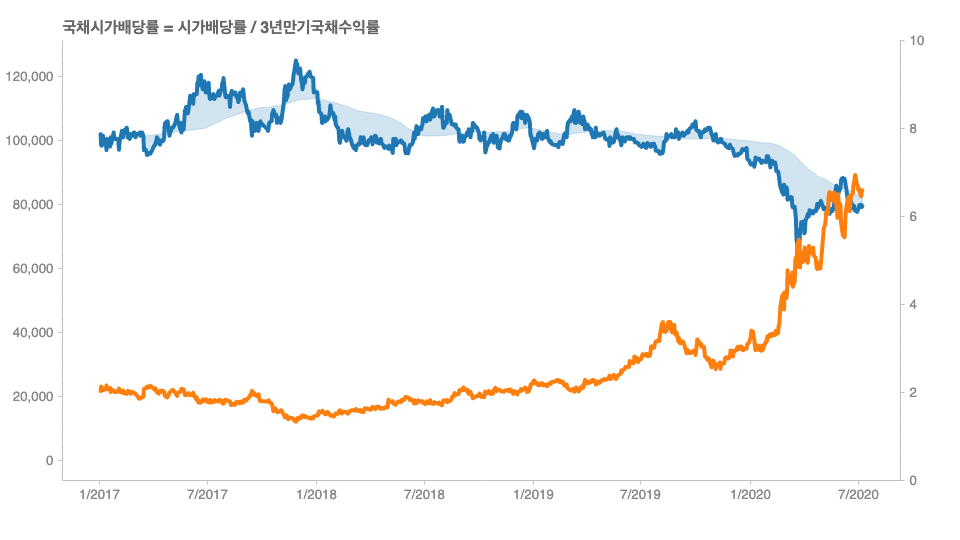

In [26]:
from IPython.display import Image
Image("img/033780_yield_div.png")

In [145]:
obv = df1[['날짜', '종가', '거래량']]
obv['obv'] = np.where(obv['종가'] > obv['종가'].shift(1), obv['거래량'], 
         np.where(obv['종가'] < obv['종가'].shift(1), -obv['거래량'], 0)).cumsum()


# days=[5, 10, 20, 60, 120]
# for rolling in days:
#     ma = 'obv{}'.format(rolling)
#     obv[ma] = obv['obv'].rolling(rolling).mean()
    
    
ch = chartify.Chart(blank_labels=True, 
                    x_axis_type='datetime',
                    y_axis_type='linear',
                    second_y_axis=False)

ch.set_subtitle(
        "On-balance volume (OBV), technical trading momentum indicator that uses volume flow."
)

ch.plot.line(
    data_frame=obv,
    x_column='날짜',
    y_column='obv'
)
ch.show()

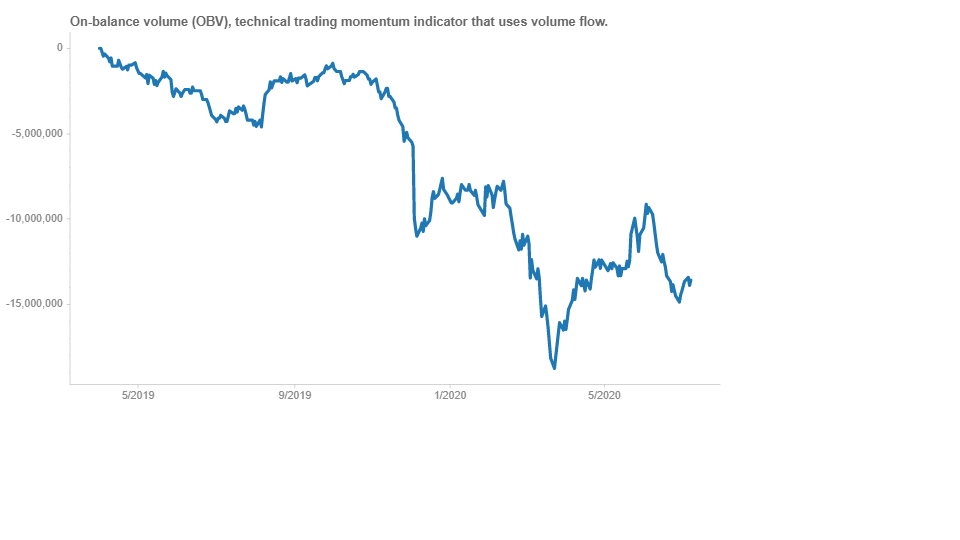

In [146]:
from IPython.display import Image
Image("img/033780_obv.png")